# Lab 9 

## Integrantes: 
- **Nombre:** Juan Avila - 20090
- **Nombre:** Sebastian Aristondo - 20880
- **Nombre:** Daniel González - 20293
- **Nombre:** Manuel Archila - 161250
- **Nombre:** Diego Franco - 20240


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import random as rand
import torch.utils.data as data

# Task 1: Práctica

## 1. Preparacion de datos

a.  Limpieza de datos: Maneje valores faltantes, anomalías o valores atípicos en el conjunto de datos.


b. Transformación de datos: Convierta los datos a un formato adecuado para modelar, incluyendo normalización o escalado si es necesario.


In [ ]:
data = pd.read_csv('./Data/train.csv')
data.head(-10)

In [ ]:
data.isnull().sum()

In [ ]:
data.info()

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data.info()

## 2.   Preprocesamiento de datos

In [ ]:
print('Min date from train set: %s' % data['date'].min().date())
print('Max date from train set: %s' % data['date'].max().date())

ultimo_mes = data['date'].max()
primer_mes = ultimo_mes - pd.DateOffset(months=3)

train = data[data['date'] < primer_mes]
test = data[data['date'] >= primer_mes]

In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
store_daily_sales_test = test.groupby(['store', 'date'], as_index=False)['sales'].sum()

#item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()


In [ ]:
store_daily_sales.head(-20)

In [ ]:
import matplotlib.pyplot as plt

rows = 2  
cols = 5  

fig, axs = plt.subplots(rows, cols, figsize=(20, 8))
colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple', 'tab:brown']

for i in range(1, 11):
    row = (i - 1) // cols  
    col = (i - 1) % cols  

    temp = store_daily_sales[store_daily_sales.store == i]
    axs[row, col].plot(temp['date'], temp['sales'], color=colores[i-1])
    axs[row, col].set_title('Store %d' % i)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Sales')

plt.tight_layout()
fig.suptitle('Store Daily Sales', fontsize=16)
plt.show()


## 3.   Selección de modelo


Como grupo decidimos que implementaríamos una LSTM

## 4.   Arquitectura modelo

- a. Diseñe la arquitectura de la red neuronal, que puede incluir:
- i. Capas LSTM/GRU/Conv1D con unidades o filtros adecuados.
- ii. Capas adicionales como capas Densas para predicciones finales.
- iii. Capas de dropout para evitar el overfitting.
- iv. Otros componentes como la normalización por batches, funciones de activación y funciones avanzadas como mecanismos de atención.

In [ ]:
scaler = MinMaxScaler()

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    datos = data[['sales']].values.astype('float32')
    datos = scaler.fit_transform(datos)
    for i in range(data.shape[0] - seq_length):
        seq = datos[i:i+seq_length]
        label = datos[i+1:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)
        
    sequences = np.array(sequences)
    labels = np.array(labels)
    torch_sequences = torch.tensor(sequences)
    torch_labels = torch.tensor(labels)
    return torch_sequences, torch_labels


In [48]:
def get_data(data, sequence_length=5):
    sequence_length = sequence_length
    X, y = create_sequences(data, sequence_length)
    return X, y


## 5.   Entrenamiento

In [40]:
def graph_loss(loss_train, loss_test, model):
    # Visualización del rendimiento
    epoch = np.arange(len(loss_train))
    plt.figure()
    plt.title('Loss modelo ' + str(model))
    plt.plot(epoch, loss_train, 'r', label='Training',)
    plt.plot(epoch, loss_test, 'b', label='Test')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('RMSE')
    plt.show()

In [35]:
def train(modelo, loader, n_epochs, model, optimizer, criterion, X_train, y_train, X_test, y_test, device):
    loss_train = []
    loss_test = []
    print("Train - Modelo", modelo)
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            X_batch = X_batch# .to(device)
            y_batch = y_batch# .to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # if epoch % 10 == 0:
        #     print(f'Epoch: {epoch:3} loss: {loss.item():10.8f}')
        if epoch % 100 != 0 and epoch != n_epochs-1:
            continue  
        model.eval()
        
        
        with torch.no_grad():
             #X_train = X_train.to(device)
            # Prediccion
            y_pred = model(X_train)
            # Calculo del RMSE - Root Mean Square Error
            train_rmse = np.sqrt(criterion(y_pred, y_train))
            # Prediccion sobre validation
            y_pred = model(X_test)
            # Calculo del RMSE para validation
            test_rmse = np.sqrt(criterion(y_pred, y_test))
            loss_train.append(train_rmse)
            loss_test.append(test_rmse)
        
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return loss_train, loss_test

In [36]:
if torch.cuda.is_available():
    # Crea una variable de dispositivo para la GPU
    device = torch.device("cuda")
else:
    # Si no hay GPU, utiliza la CPU
    device = torch.device("cpu")

In [46]:
from torch.utils.data import DataLoader

input_size = 1
hidden_layer_size = 50
output_size = 1
modelos = []
losses = []

for tienda in range(0, 2):
    tienda += 1
    
    LSTM_i = LSTM(input_size, hidden_layer_size, output_size)
    # LSTM_i.to(device)
    optimizer = optim.Adam(LSTM_i.parameters(), lr=0.001)
    loss_function = nn.MSELoss() 
    
    x_train, y_train = get_data(store_daily_sales[store_daily_sales['store'] == tienda])
    x_test, y_test = get_data(store_daily_sales_test[store_daily_sales_test['store'] == tienda])

    loader = DataLoader((x_train, y_train), batch_size=4, shuffle=True)
    loss_train, loss_test = train(tienda, loader, 1000, LSTM_i, optimizer, loss_function, x_train, y_train, x_test, y_test, device)
    losses.append((loss_train, loss_test))
    modelos.append(LSTM_i)


Train - Modelo 1
Epoch 0: train RMSE 0.3798, test RMSE 0.4653
Epoch 100: train RMSE 0.1673, test RMSE 0.2320
Epoch 200: train RMSE 0.1340, test RMSE 0.2077
Epoch 300: train RMSE 0.1265, test RMSE 0.2016
Epoch 400: train RMSE 0.1233, test RMSE 0.1987
Epoch 500: train RMSE 0.1236, test RMSE 0.2015
Epoch 600: train RMSE 0.1222, test RMSE 0.1992
Epoch 700: train RMSE 0.1227, test RMSE 0.2007
Epoch 800: train RMSE 0.1212, test RMSE 0.1985
Epoch 900: train RMSE 0.1214, test RMSE 0.1991
Epoch 999: train RMSE 0.1225, test RMSE 0.2013
Train - Modelo 2
Epoch 0: train RMSE 0.3690, test RMSE 0.4558
Epoch 100: train RMSE 0.1728, test RMSE 0.2398
Epoch 200: train RMSE 0.1383, test RMSE 0.2148
Epoch 300: train RMSE 0.1310, test RMSE 0.2101
Epoch 400: train RMSE 0.1289, test RMSE 0.2095
Epoch 500: train RMSE 0.1272, test RMSE 0.2074
Epoch 600: train RMSE 0.1275, test RMSE 0.2089
Epoch 700: train RMSE 0.1261, test RMSE 0.2064
Epoch 800: train RMSE 0.1263, test RMSE 0.2074
Epoch 900: train RMSE 0.1258, 

## 6.    Evaluación modelo

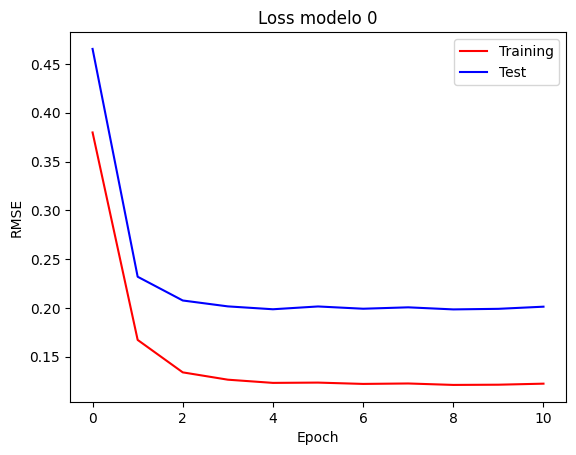

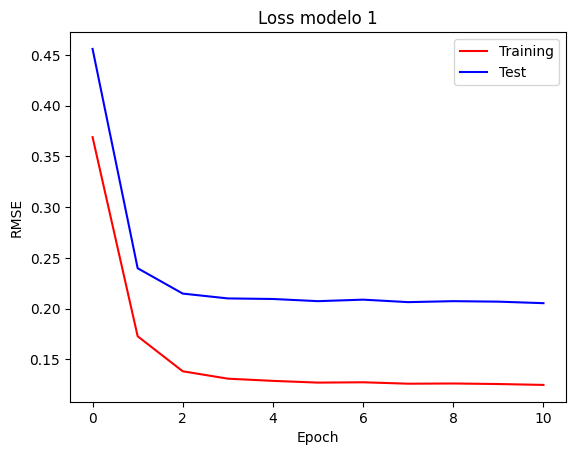

In [47]:
for i, (loss_train, loss_test) in enumerate(losses):
    graph_loss(loss_train, loss_test, i)

## 7.   Ajuste hiperparámetros

In [ ]:
import random

# Define the hyperparameter space
hidden_layer_sizes = [20, 50, 100, 150]
learning_rates = [0.001, 0.01, 0.1]
sequence_lengths = [3, 5, 7, 10]

# Define a function to perform evaluation for a given hyperparameter combination
def evaluate_hyperparameters(hidden_size, lr, seq_length, store_data, store_data_test):
    # Create model with given hyperparameters
    model = LSTM(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    x_train, y_train = get_data(store_data[store_data['store'] == tienda].copy(), seq_length)
    x_test, y_test = get_data(store_data_test[store_data_test['store'] == tienda].copy(), seq_length)

    loader = DataLoader((x_train, y_train), batch_size=4, shuffle=True)
    _, loss_test = train(loader, 500, model, optimizer, loss_function, x_train, y_train, x_test, y_test, device)

    # Return the final test loss
    return loss_test[-1]

# Random search
best_loss = float('inf')
best_hyperparameters = None

# Number of random search iterations
n_iterations = 10

for _ in range(n_iterations):
    # Sample a random hyperparameter combination
    hidden_size = random.choice(hidden_layer_sizes)
    lr = random.choice(learning_rates)
    seq_length = random.choice(sequence_lengths)

    # Evaluate the current combination
    loss = evaluate_hyperparameters(hidden_size, lr, seq_length, store_daily_sales, store_daily_sales_test)
    print(f"Evaluating: Hidden Size = {hidden_size}, Learning Rate = {lr}, Sequence Length = {seq_length} -> Loss = {loss}")

    # Update best loss and best hyperparameters
    if loss < best_loss:
        best_loss = loss
        best_hyperparameters = (hidden_size, lr, seq_length)

print(best_hyperparameters, best_loss)


## 8.   Forecasting

In [42]:
# Define the inverse transform function for the scaler
def inverse_transform(data, scaler):
    data_2D = data.squeeze(-1)
    return scaler.inverse_transform(data_2D)

# Define the predict function
def predict(model, data, seq_length):
    sequences, _ = create_sequences(data, seq_length)
    with torch.no_grad():
        predictions = model(sequences)
    return predictions


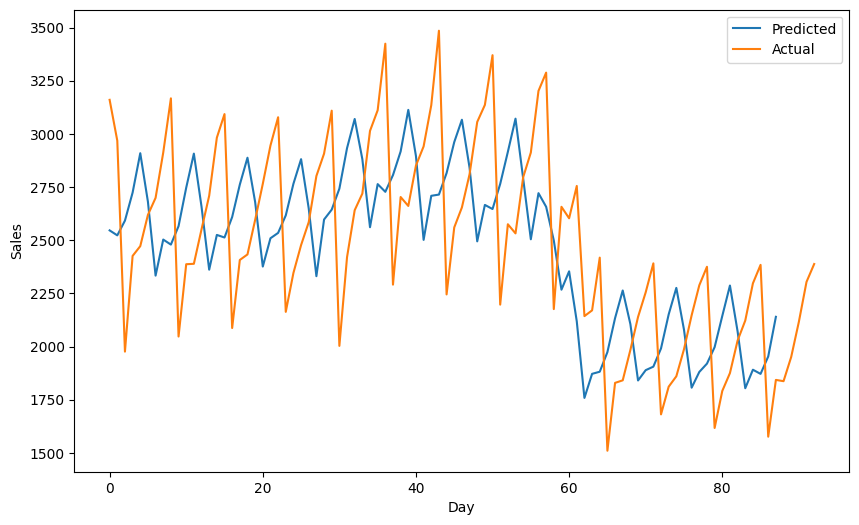

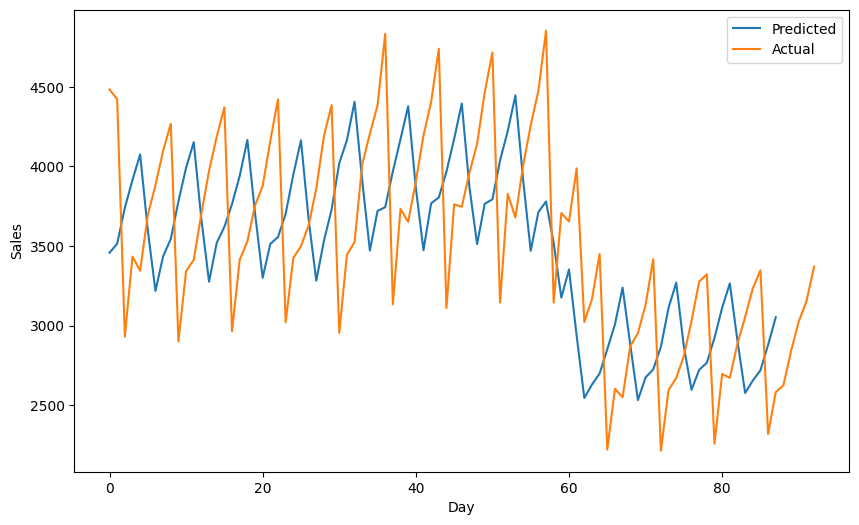

In [45]:
tienda = 1
for modelo in modelos:
    
    test_data = store_daily_sales_test[store_daily_sales_test['store'] == tienda]

    predicciones_tienda = predict(modelo, test_data, 5)
    original_predictions = inverse_transform(predicciones_tienda.numpy(), scaler)
    tienda += 1

    # Use only the last point from each sequence for plotting
    unique_predictions = original_predictions[:, -1]

    plt.figure(figsize=(10, 6))
    plt.plot(unique_predictions, label='Predicted')
    plt.plot(test_data['sales'].values, label='Actual')
    plt.xlabel('Day')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

## 9.   Visualización

## 10.  Interpretabilidad del modelo

# Task 2

**1. ¿Cuál es el problema del gradiente de fuga de las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de serires temporales ?** 

    - El problema de graiente decendiente ocurre cuando los gradientes de capas anterior se vuelven muy pequeñas a meidida que se retropropagan hacia atrás durante el entrenamiento.Como resultado, los pesos en las capas anteriores se actualizan de manera muy gradual o, en algunos casos, casi no se actualizan en absoluto. Esto dificulta el aprendizaje de dependencias a largo plazo en datos secuenciales, lo que puede dar como resultado predicciones inexactas.
    
**2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso?**
    
    - La estacionalidad se aborda con la diferenciación, la cual consiste en restar el valor de la observación en el tiempo t-1 al valor de la observación en el tiempo t. Esto se hace para que los datos sean estacionarios y se puedan utilizar en el modelo. Esto ayuda a estabilizar la media de la serie, lo que a su vez ayuda a estabilizar las predicciones.

**3.¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo?** 

    - Este concepto hace referencia a la cantidad de pasos de tiempo anteriores que se utilizarán como entrada para predecir el siguiente paso de tiempo. Si se utiliza un tamaño de ventana pequeño, el modelo solo podrá capturar patrones a corto plazo, mientras que si se utiliza un tamaño de ventana grande, el modelo podrá capturar patrones a largo plazo.

    El tamaño juega un papel bastante importante en la capacidad del modelo. Por ejemplo, un tamaño de ventana 